In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, average_precision_score
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

np.random.seed(99)

def bootstrap_sd(y_true, y_prob, n_bootstraps=1000, random_state=42, max_workers=60):
    np.random.seed(random_state)
    metrics_list = []
    n = len(y_true)

    def evaluate_single_bootstrap(y_true_boot, y_prob_boot):
        auc = roc_auc_score(y_true_boot, y_prob_boot)
        ap = average_precision_score(y_true_boot, y_prob_boot)
        return {'auc': auc, 'ap': ap}
        
    def compute_metrics(indices):
        y_true_boot = y_true.iloc[indices] if hasattr(y_true, 'iloc') else y_true[indices]
        y_prob_boot = y_prob[indices]
        return evaluate_single_bootstrap(y_true_boot, y_prob_boot)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        with tqdm(total=n_bootstraps, desc="Bootstrap Progress") as pbar:
            for _ in range(n_bootstraps):
                indices = np.random.choice(n, n, replace=True)
                futures.append(executor.submit(compute_metrics, indices))
                pbar.update(1)

        for future in futures:
            metrics_list.append(future.result())

    metrics_df = pd.DataFrame(metrics_list)
    auc = metrics_df['auc'].mean()
    auc_std = metrics_df['auc'].std()
    ap = metrics_df['ap'].mean()
    ap_std = metrics_df['ap'].std()

    return {
        'auc': auc,
        'auc_std': auc_std,
        'ap': ap,
        'ap_std': ap_std
    }

model1 = joblib.load("/home/luo_wenjin/data/BAH_PRS/version10/ml_dat/predictions_config_1.pkl")
model2 = joblib.load("/home/luo_wenjin/data/BAH_PRS/version10/ml_dat/predictions_config_2.pkl")
model3 = joblib.load("/home/luo_wenjin/data/BAH_PRS/version10/ml_dat/predictions_config_3.pkl")

<Figure size 800x800 with 0 Axes>

Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 197.84it/s]


Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.27it/s]


Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.59it/s]


Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 226.56it/s]


(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 0, '1 - Specificity')

Text(0, 0.5, 'Sensitivity')

Text(0.5, 1.0, 'ROC Curves')

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0')])

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

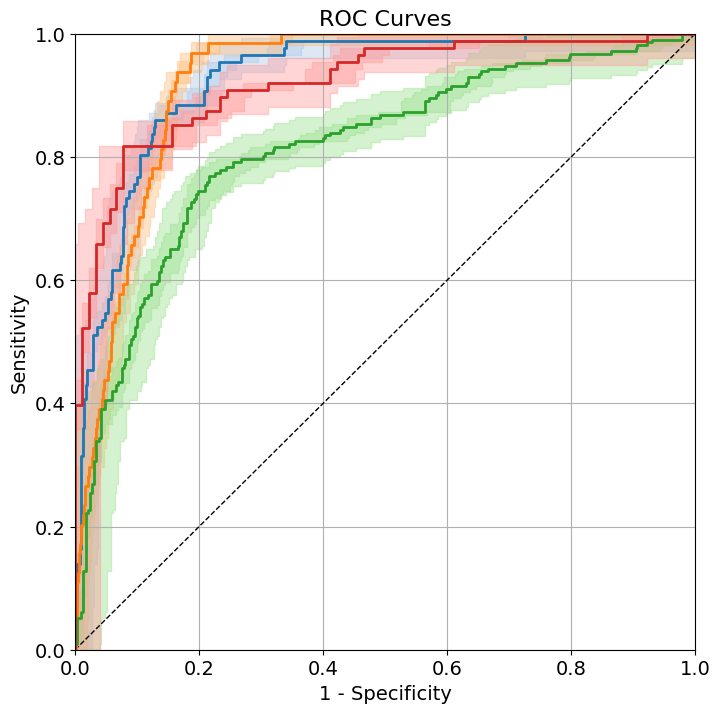

In [2]:
true_labels_list = [model1['y_test'], 
                    model1['y1'], 
                    model1['y2'], 
                    model1['y3']] 
prob_estimates_list = [model1['y_prob'], 
                       model1['y_prob1'], 
                      model1['y_prob2'], 
                      model1['y_prob3']]  

colors = plt.get_cmap('tab20')(np.arange(0,20))

plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Chance')

for i, (y_true, y_prob) in enumerate(zip(true_labels_list, prob_estimates_list)):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    boot_sd = bootstrap_sd(np.asarray(y_true), 
                           np.asarray(y_prob), 
                           n_bootstraps=1000, 
                           random_state=42)
    sd = boot_sd['auc_std']
    
    tprs_upper = np.minimum(tpr + 1.96 * sd, 1)
    tprs_lower = np.maximum(tpr - 1.96 * sd, 0)
    fpr_upper = np.minimum(fpr + 1.96 * sd, 1)
    fpr_lower = np.maximum(fpr - 1.96 * sd, 0)
    
    plt.plot(fpr, tpr, color=colors[2*i], lw=2)
    plt.fill_between(fpr, tprs_lower, tprs_upper, color=colors[2*i + 1], alpha=.4)
    plt.fill_betweenx(tpr, fpr_lower, fpr_upper, color=colors[2*i + 1], alpha=.4)

# Common plot settings
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("1 - Specificity", fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)
plt.title('ROC Curves', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
#plt.legend(loc='lower right', fontsize=12)
plt.savefig('/home/luo_wenjin/data/BAH_PRS/version10/ml_dat/roc_curve_model1.tiff', dpi=300)
plt.show()

<Figure size 800x800 with 0 Axes>

Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.51it/s]


Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.04it/s]


Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.77it/s]


Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 213.17it/s]


(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 0, '1 - Specificity')

Text(0, 0.5, 'Sensitivity')

Text(0.5, 1.0, 'ROC Curves')

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0')])

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

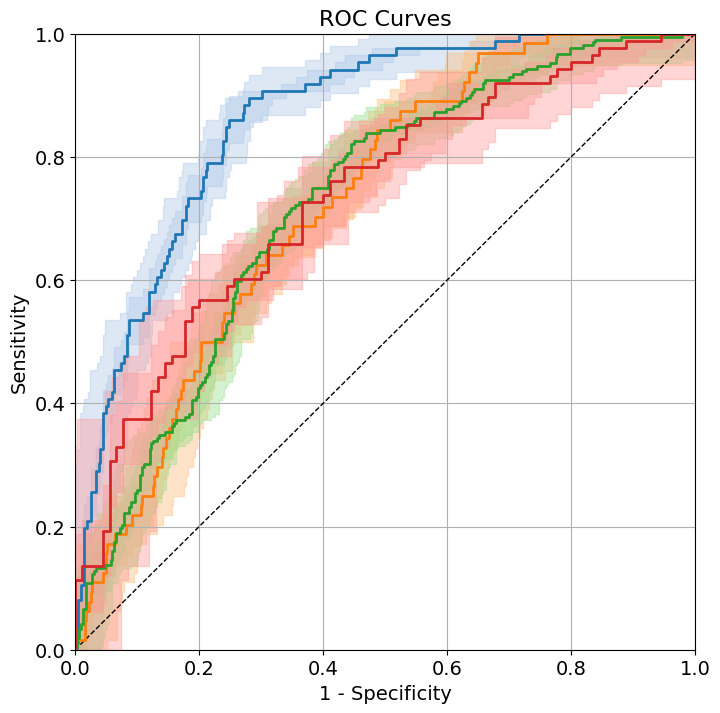

In [3]:
true_labels_list = [model2['y_test'], 
                    model2['y1'], 
                    model2['y2'], 
                    model2['y3']] 
prob_estimates_list = [model2['y_prob'], 
                       model2['y_prob1'], 
                      model2['y_prob2'], 
                      model2['y_prob3']]  

colors = plt.get_cmap('tab20')(np.arange(0,20))

plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Chance')

for i, (y_true, y_prob) in enumerate(zip(true_labels_list, prob_estimates_list)):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    boot_sd = bootstrap_sd(np.asarray(y_true), 
                           np.asarray(y_prob), 
                           n_bootstraps=1000, 
                           random_state=42)
    sd = boot_sd['auc_std']
    
    tprs_upper = np.minimum(tpr + 1.96 * sd, 1)
    tprs_lower = np.maximum(tpr - 1.96 * sd, 0)
    fpr_upper = np.minimum(fpr + 1.96 * sd, 1)
    fpr_lower = np.maximum(fpr - 1.96 * sd, 0)
    
    plt.plot(fpr, tpr, color=colors[2*i], lw=2)
    plt.fill_between(fpr, tprs_lower, tprs_upper, color=colors[2*i + 1], alpha=.4)
    plt.fill_betweenx(tpr, fpr_lower, fpr_upper, color=colors[2*i + 1], alpha=.4)

# Common plot settings
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("1 - Specificity", fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)
plt.title('ROC Curves', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
#plt.legend(loc='lower right', fontsize=12)
plt.savefig('/home/luo_wenjin/data/BAH_PRS/version10/ml_dat/roc_curve_model2.tiff', dpi=300)
plt.show()

<Figure size 800x800 with 0 Axes>

Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.05it/s]


Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.85it/s]


Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.25it/s]


Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 214.40it/s]


(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 0, '1 - Specificity')

Text(0, 0.5, 'Sensitivity')

Text(0.5, 1.0, 'ROC Curves')

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0')])

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

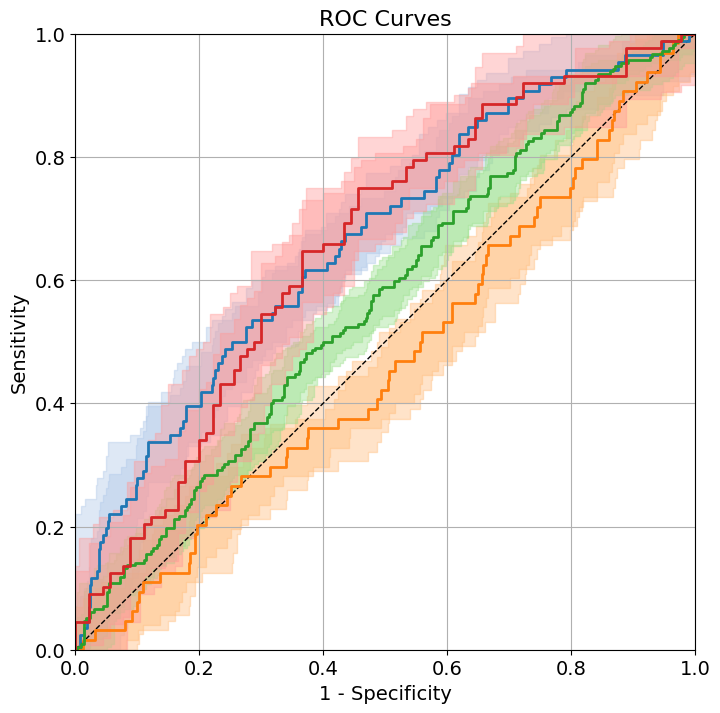

In [4]:
true_labels_list = [model3['y_test'], 
                    model3['y1'], 
                    model3['y2'], 
                    model3['y3']] 
prob_estimates_list = [model3['y_prob'], 
                       model3['y_prob1'], 
                      model3['y_prob2'], 
                      model3['y_prob3']]  

colors = plt.get_cmap('tab20')(np.arange(0,20))

plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Chance')

for i, (y_true, y_prob) in enumerate(zip(true_labels_list, prob_estimates_list)):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    boot_sd = bootstrap_sd(np.asarray(y_true), 
                           np.asarray(y_prob), 
                           n_bootstraps=1000, 
                           random_state=42)
    sd = boot_sd['auc_std']
    
    tprs_upper = np.minimum(tpr + 1.96 * sd, 1)
    tprs_lower = np.maximum(tpr - 1.96 * sd, 0)
    fpr_upper = np.minimum(fpr + 1.96 * sd, 1)
    fpr_lower = np.maximum(fpr - 1.96 * sd, 0)
    
    plt.plot(fpr, tpr, color=colors[2*i], lw=2)
    plt.fill_between(fpr, tprs_lower, tprs_upper, color=colors[2*i + 1], alpha=.4)
    plt.fill_betweenx(tpr, fpr_lower, fpr_upper, color=colors[2*i + 1], alpha=.4)

# Common plot settings
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("1 - Specificity", fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)
plt.title('ROC Curves', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
#plt.legend(loc='lower right', fontsize=12)
plt.savefig('/home/luo_wenjin/data/BAH_PRS/version10/ml_dat/roc_curve_model3.tiff', dpi=300)
plt.show()